# Développez un outil de prévision de la consommation d'énergie

Context: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.
This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy<br>
2.time: time in format hh:mm:ss<br>
3.globalactivepower: household global minute-averaged active power (in kilowatt)<br>
4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)<br>
5.voltage: minute-averaged voltage (in volt)<br>
6.global_intensity: household global minute-averaged current intensity (in ampere)<br>
7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).<br>
8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.<br>
9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# EDA

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from datetime import datetime
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math

# Preprocessing

In [209]:
df.head()

,Date,Time,Global_active_power,day,month,year
Datetime,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,16,12,2006
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,16,12,2006
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,16,12,2006
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,16,12,2006
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,16,12,2006


In [210]:
# resample data by hour
data_h=df.resample('H').mean()

In [211]:
data_h.head()

,Global_active_power
Datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [212]:
# drop NaN in data
data_h.dropna(inplace=True)

In [216]:
# numpy.ndarray
dataset = data_h.Global_active_power.values 

# float type
dataset = dataset.astype('float32')

# reshape
dataset = np.reshape(dataset, (-1, 1))

# scaling
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split train & test
train_size = int(len(dataset) * 0.30)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(train.shape, test.shape)

(10250, 1) (23918, 1)


In [217]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [225]:
# reshape into X=t and Y=t+1
look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_train.shape, y_train.shape)

(10225, 24) (10225,)


In [226]:
# reshape X input to be 3D : samples, time steps, features
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, X_test.shape)

(10225, 1, 24) (23893, 1, 24)


In [228]:
#model LSTM

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile
model.compile(loss='mean_squared_error', optimizer='adam')

# fit
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# summary
model.summary()

Epoch 1/10
1023/1023 [==============================] - 13s 9ms/step - loss: 0.0137 - val_loss: 0.0091
Epoch 2/10
1023/1023 [==============================] - 8s 8ms/step - loss: 0.0114 - val_loss: 0.0089
Epoch 3/10
1023/1023 [==============================] - 8s 8ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 4/10
1023/1023 [==============================] - 8s 8ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 5/10
1023/1023 [==============================] - 8s 8ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 6/10
1023/1023 [==============================] - 9s 8ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 7/10
1023/1023 [==============================] - 9s 9ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 8/10
1023/1023 [==============================] - 9s 9ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 9/10
1023/1023 [==============================] - 9s 9ms/step - loss: 0.0106 - val_loss: 0.0082
Epoch 10/10
1023/1023 [==============================] - 8s 8ms/step - loss: 0.01

In [229]:
# predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.49837720677974456
Train Root Mean Squared Error: 0.6644519307646216
Test Mean Absolute Error: 0.4450162722295971
Test Root Mean Squared Error: 0.5866305521513835


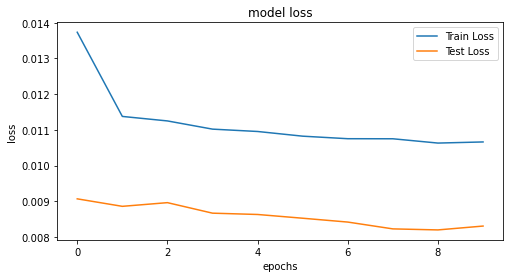

In [230]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

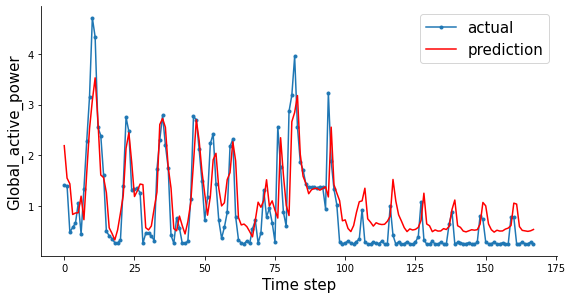

In [231]:
# compare the actual and predictions for the last 7 days (168 hours)

aa=[x for x in range(168)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:168], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:168], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();